# Cell-cell interaction analysis on seqFISH+ data

# 1. Prepare data

In [1]:
from pathlib import Path, PurePath
from typing import Optional, Union
from anndata import AnnData
import numpy as np
from PIL import Image
import pandas as pd
import stlearn as st
import scanpy
import scipy
import random
from matplotlib import pyplot as plt
from typing import Optional, Union

In [2]:
count_matrix_file = "C:\\Users\\uqjxu8\\GIH\\Bioinformatics\\SPA\\Paper_resubmittion\\seqfish\\seqFISH-PLUS\\sourcedata\\sourcedata\\cortex_svz_counts.csv"
spatial_file = "C:\\Users\\uqjxu8\\GIH\\Bioinformatics\\SPA\\Paper_resubmittion\\seqfish\\seqFISH-PLUS\\sourcedata\\sourcedata\\cortex_svz_cellcentroids.csv"
field = 5
scale = 1.0
quality = 'hires'
distance = 200

count = pd.read_table(count_matrix_file,header=0,sep=',')
spatial = pd.read_table(spatial_file,index_col=False,sep=',')

data = AnnData(count)

data.obs["imagecol"] = (max(spatial["Y"])-spatial["Y"]).values*scale
data.obs["imagerow"] = spatial["X"].values*scale

# Create image
max_size = np.max([data.obs["imagecol"].max(),data.obs["imagerow"].max()])
max_size = int(max_size + 0.1*max_size)

image = Image.new('RGB', (max_size, max_size), (255, 255, 255))
imgarr = np.array(image)

library_id = "seqFISH+"

data.uns["spatial"] = {}
data.uns["spatial"][library_id] = {}
data.uns["spatial"][library_id]["images"] = {}
data.uns["spatial"][library_id]["images"][quality] = imgarr
data.uns["spatial"]["use_quality"] = quality
data.uns["spatial"][library_id]["scalefactors"] = {}
data.uns["spatial"][library_id]["scalefactors"]["tissue_" + quality + "_scalef"] = scale
data.obsm["spatial"] = spatial[["X","Y"]].values

data.obs['sum_counts'] = np.array(data.X.sum(axis=1))


C:\Users\uqjxu8\AppData\Local\Continuum\anaconda3\envs\stlearn\lib\site-packages\anndata\_core\anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [3]:
cluster_file = "C:\\Users\\uqjxu8\\GIH\\Bioinformatics\\SPA\\Paper_resubmittion\\seqfish\\seqFISH-PLUS\\celltype_annotations\\cortex_svz_cell_type_annotations.csv"
cluster = pd.read_table(cluster_file,header=0,index_col=0,sep=',')
data.obs['paper_cluster'] = pd.Categorical(cluster['louvain'].astype('str'))
fov_file = "C:\\Users\\uqjxu8\\GIH\\Bioinformatics\\SPA\\Paper_resubmittion\\seqfish\\seqFISH-PLUS\\sourcedata\\sourcedata\\cortex_svz_cellcentroids.csv"
fov = pd.read_table(fov_file,header=0,index_col=None,sep=',')

# 2 Preprocessing

### 2.1. filter, normalize, scale & PCA

In [4]:
st.pp.filter_genes(data,min_cells=3)
st.pp.normalize_total(data)
st.pp.scale(data)
data.obsm['scaled'] = pd.DataFrame(data.X, data.obs_names, data.var_names)

Normalization step is finished in adata.X
Scale step is finished in adata.X


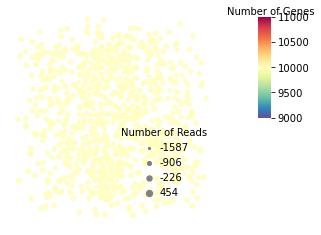

In [5]:
def QC_plot(
        adata: AnnData,
        library_id: str = None,
        name: str = None,
        data_alpha: float = 0.8,
        tissue_alpha: float = 1.0,
        cmap: str = "Spectral_r",
        spot_size: tuple = (5, 40),
        show_color_bar: bool = True,
        show_size_legend: bool = True,
        show_axis: bool = False,
        cropped: bool = True,
        margin: int = 100,
        output: str = None,
) -> Optional[AnnData]:
    """\
        QC plot for sptial transcriptomics data.
        Parameters
        ----------
        adata
            Annotated data matrix.
        library_id
            Library id stored in AnnData.
        data_alpha
            Opacity of the spot.
        tissue_alpha
            Opacity of the tissue.
        cmap
            Color map to use.
        spot_size
            Size of the spot (min, max).
        show_color_bar
            Show color bar or not.
        show_axis
            Show axis or not.
        show_size_legend
            Show size legend or not.
        name
            Name of the output figure file.
        output
            Save the figure as file or not.
        copy
            Return a copy instead of writing to adata.
        Returns
        -------
        Nothing
        """

    imagecol = adata.obs["imagecol"]
    imagerow = adata.obs["imagerow"]
    from sklearn.preprocessing import MinMaxScaler
    reads_per_spot = adata.to_df().sum(axis=1)
    scaler = MinMaxScaler(feature_range=spot_size)
    reads_per_spot_size = scaler.fit_transform(
        reads_per_spot.to_numpy().reshape(-1, 1))
    genes_per_spot = adata.to_df().astype(bool).sum(axis=1)

    #plt.rcParams['figure.dpi'] = dpi

    # Option for turning off showing figure
    plt.ioff()

    # Initialize matplotlib
    fig, a = plt.subplots()

    vmin = min(genes_per_spot)
    vmax = max(genes_per_spot)
    # Plot scatter plot based on pixel of spots
    plot = a.scatter(adata.obs["imagecol"], adata.obs["imagerow"], edgecolor="none", alpha=data_alpha,
                     s=reads_per_spot_size, marker="o",
                     vmin=vmin, vmax=vmax, cmap=plt.get_cmap(cmap), c=genes_per_spot)

    if show_color_bar:
        cb = plt.colorbar(plot, cax=fig.add_axes(
            [0.85, 0.5, 0.03, 0.35]), cmap=cmap)
        cb.ax.set_xlabel('Number of Genes', fontsize=10)
        cb.ax.xaxis.set_label_coords(0.98, 1.10)
        cb.outline.set_visible(False)

    if show_size_legend:
        size_min, size_max = spot_size
        markers = [size_min, size_min + 1 / 3 * (size_max - size_min),
                   size_min + 2 / 3 * (size_max - size_min), size_max]
        legend_markers = [plt.scatter([], [], s=i, c="grey") for i in markers]
        labels = [str(int(scaler.inverse_transform(np.array(i).reshape(1, 1))))
                  for i in markers]
        fig.legend(handles=legend_markers, labels=labels, loc='lower right', bbox_to_anchor=(0.5, 0.1),
                   scatterpoints=1, frameon=False, handletextpad=0.1, title="Number of Reads")

    if not show_axis:
        a.axis('off')
    if library_id is None:
        library_id = list(adata.uns["spatial"].keys())[0]

    image = adata.uns["spatial"][library_id]["images"][adata.uns["spatial"]["use_quality"]]
    # Overlay the tissue image
    a.imshow(image, alpha=tissue_alpha, zorder=-1, )

    if cropped:
        a.set_xlim(imagecol.min() - margin,
                imagecol.max() + margin)

        a.set_ylim(imagerow.min() - margin,
                imagerow.max() + margin)
        
        a.set_ylim(a.get_ylim()[::-1])
        #plt.gca().invert_yaxis()

    # fig.tight_layout()
    if output is not None:
        fig.savefig(output + "/" + name, dpi=plt.figure().dpi,
                    bbox_inches='tight', pad_inches=0)

    plt.show()
QC_plot(data)

Trying to set attribute `.uns` of view, copying.


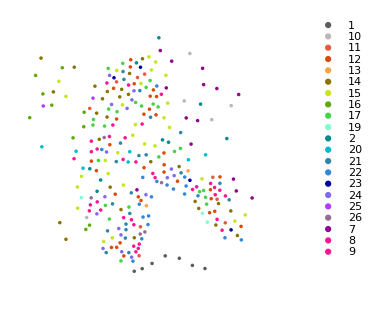

In [6]:
data = data[fov['Field of View']==5]
st.pl.cluster_plot(data, use_label='paper_cluster', cmap='jana_40', dpi=100, tissue_alpha=1)

# 3. Cell-cell interaction analysis

### 3.1 Cell type diversity based on clustering

In [7]:
#st.tl.cci.het.count(data, use_clustering='paper_cluster', distance=distance)
#st.pl.het_plot(data, use_het='cci_het', dpi=100, cmap='Blues', name='het_louvain', output='.')

### 3.2 Clustering based on Ligand-Receptor (L-R) co-expression

#### Read in user input LR pair

In [8]:
data.uns["lr"] = ['Cyr61_Itgb5']

#### calculate the proportion of known ligand-receptor co-expression in the neighbouring spots

Altogether 2 valid L-R pairs
L-R interactions with neighbours are counted and stored into adata\.uns['cci_lr']


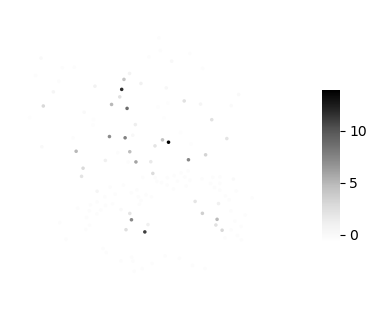

In [9]:
st.tl.cci.base.lr(adata=data, use_data='scaled', distance=distance)
st.pl.het_plot(data, use_het='cci_lr', cmap='Greys', dpi=100, name='cci_lr', show_color_bar=True, output='.')

#### Merge CCI cell type diversity and L-R coexpression scores

In [10]:
# merge the number of spots belonging to largest lr cci cluster, with the number of different cell types within each window
#st.tl.cci.merge(data, use_lr='cci_lr', use_het='cci_het')
#st.pl.het_plot(data, use_het='merged', dpi=100, cmap='Greys', name='merged', output='.')
data.uns['merged'] = data.uns['cci_lr']

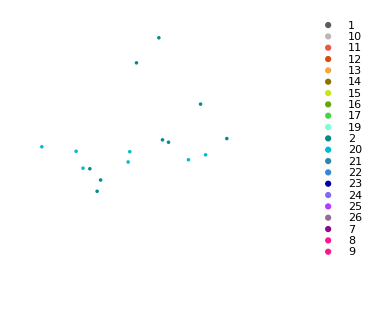

In [11]:
st.pl.cluster_plot(data, use_label='paper_cluster', list_cluster=[2, 20], cmap='jana_40', dpi=100, tissue_alpha=1)

Trying to set attribute `.uns` of view, copying.


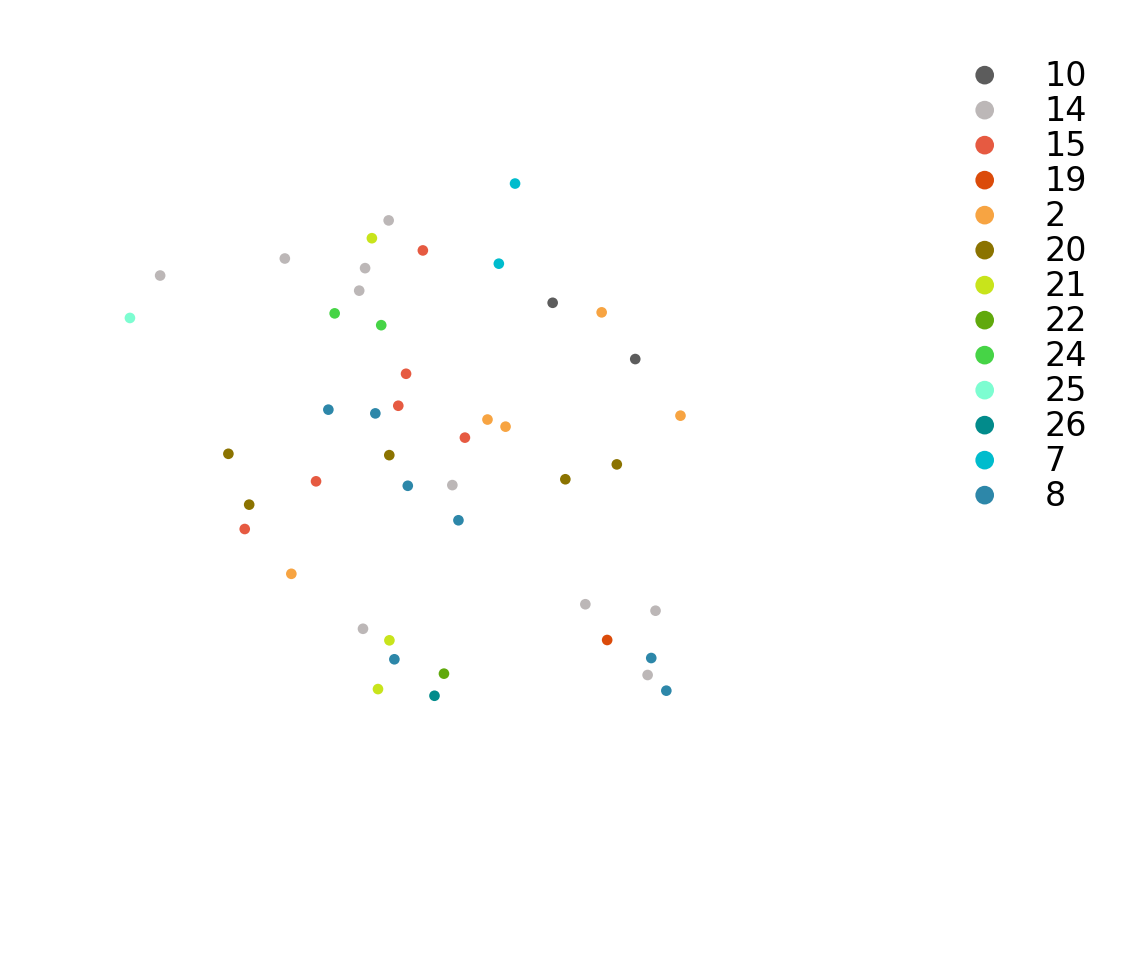

Trying to set attribute `.uns` of view, copying.


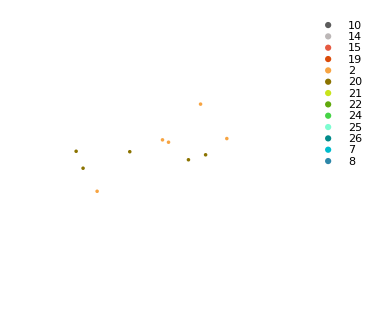

In [12]:
st.pl.cluster_plot(data[data.uns['merged']>0], use_label='paper_cluster', cmap='jana_40', dpi=300, tissue_alpha=1)
st.pl.cluster_plot(data[data.uns['merged']>0], use_label='paper_cluster', list_cluster=[2, 20], cmap='jana_40', dpi=100, tissue_alpha=1)

### Grid-based analysis

In [13]:
st.tl.cci.het.count_grid(data, use_clustering='paper_cluster', num_row=20, num_col=20, radius=1)
st.pl.grid_plot(data, use_het='cci_het_grid', num_row=20, num_col=20, dpi=100, name='het_grid_louvain', output='.')

KeyError: 'paper_cluster'

In [ ]:
st.tl.cci.base.lr_grid(adata=data, use_data='scaled', num_row=20, num_col=20, radius=1)
st.pl.grid_plot(data, use_het='cci_lr_grid', num_row=20, num_col=20, dpi=100, name='lr_grid_louvain', output='.')

In [ ]:
# merge the number of spots belonging to largest lr cci cluster, with the number of different cell types within each window
st.tl.cci.merge(data, use_lr='cci_lr_grid', use_het='cci_het_grid')
st.pl.grid_plot(data, use_het='merged', num_row=20, num_col=20, dpi=100, name='merged', output='.')

In [ ]:
st.tl.cci.het.count_grid(data, use_clustering='paper_cluster', num_row=20, num_col=20, radius=0)
st.pl.grid_plot(data, use_het='cci_het_grid', num_row=20, num_col=20, dpi=100, name='het_grid_louvain', output='.')
st.tl.cci.base.lr_grid(adata=data, use_data='scaled', num_row=20, num_col=20, radius=0)
st.pl.grid_plot(data, use_het='cci_lr_grid', num_row=20, num_col=20, dpi=100, name='lr_grid_louvain', output='.')
st.tl.cci.merge(data, use_lr='cci_lr_grid', use_het='cci_het_grid')
st.pl.grid_plot(data, use_het='merged', num_row=20, num_col=20, dpi=100, name='merged', output='.')

In [ ]:
distances = []
for i in range(data.shape[0]):
    distance = []
    for j in range(i+1, data.shape[0]):
        distance.append(np.sqrt((data.obs['imagecol'][i] - data.obs['imagecol'][j]) ** 2 + \
                   (data.obs['imagerow'][i] - data.obs['imagerow'][j]) ** 2))
    try:
        distances.append(min(distance))
    except:
        pass
np.mean(distances)